In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
import os
from scipy.optimize import root,least_squares
import math

In [2]:
#defining the coordinates for the images
def coords(n):
   
    if n == 1: #for the first image
        pt = np.array([[1593,814],[1623,1242],[2424,1662],[3358,1134],[3163,1540],[2475,480],[2446,672],[2330,2055]])
        
    if n == 2: #for the second image
        pt =  np.array([[1149,581],[1240,1090],[1800,1345],[3007,902],[2864,1428],[2178,332],[2093,484],[1812,1887]])
        
    
    return pt
    

In [3]:
#Normalizing the coordinates
def normalize_points(pts):
    T = np.zeros((3,3))
    xbar = np.mean(pts,axis=0)
    denom = np.mean(np.linalg.norm(pts - xbar,axis=1))

    var = np.sqrt(2)/denom
  
    T[:2,:2] = np.eye(2)*var
    T[:2,2] = -var*xbar
    T[2,2] = 1

    return (pts-xbar)*var, T
    

    

In [4]:
#Computing the fundamental matrix
def find_F(coords1,coords2,T1,T2,method='lm'):

    A = np.zeros((8,9))
    for i in range(8):

        x = coords1[i][0]
        y = coords1[i][1]

        x_bar = coords2[i][0]
        y_bar = coords2[i][1]

        A[i] = np.array([x_bar*x,x_bar*y,x_bar,y_bar*x,y_bar*y,y_bar,x,y,1])

    u,d,v = np.linalg.svd(np.dot(np.transpose(A),A))
    F = np.reshape(v[-1],(3,3))

    if(method == 'lm'):
        F = least_squares(cost,np.ravel(F),args=(coords1,coords2),method='lm').x
        F = F.reshape((3,3))

    F_un = np.dot(np.dot(np.transpose(T2),F),T1)
    F_un = F_un/F_un[2,2]

    U,D,V = np.linalg.svd(F_un);
    Diag = np.array([[D[0],0,0],[0,D[1],0],[0,0,0]])
    F = np.dot(np.dot(U,Diag),V)
  

    return F

In [5]:
#Computing the epipoles of the images
def epipoles(F):
    u,d,v = np.linalg.svd (F)
    e1 = np.transpose(v[-1,:])
    e2 = u[:,-1]
    e1 = e1/e1[2] 
    e2 = e2/e2[2]
    return e1,e2

In [6]:
#Coverting a vector into its matrix vector form
def matrix_vector_product(e):
    E_bar  = np.zeros((3,3))
    E_bar[0,1] = -e[2]
    E_bar[1,0] = e[2]
    E_bar[0,2] = e[1]
    E_bar[2,0] = -e[1]
    E_bar[1,2] = -e[0]
    E_bar[2,1] = e[0]
    
    return E_bar

In [7]:
#Computing canonical Projection matrix for both the images
def projection_matrix(e_bar,F):
    I = np.eye(3)
    O = np.zeros((3,1))
    P = np.c_[I, O]
    
    E_bar  = matrix_vector_product(e_bar)   
    P_bar = np.c_[E_bar@F,e_bar]
    return P,P_bar

In [8]:
#Computing world coordinates
def world_coord(P,P_bar,pt,pt_bar):
    A = np.ones((4,4))
    A[0] = pt[0]*P[2,:] - P[0,:]
    A[1] = pt[1]*P[2,:] - P[1,:]
    A[2] = pt_bar[0]*P_bar[2,:] - P_bar[0,:]
    A[3] = pt_bar[1]*P_bar[2,:] - P_bar[1,:]
    
    U, D, V = np.linalg.svd(A)
    X = V[-1,:]/V[-1,-1]
    return X

In [9]:
#optimization cost function
def cost(f,pts,pts_bar):

    F = np.reshape(f,(3,3))
    e,e_bar= epipoles(F)
    P,P_bar = projection_matrix(e_bar,F)

    tcost = []
    for i in range(len(pts)):
        X = world_coord(P,P_bar,pts[i],pts_bar[i])

        x = np.dot(P,X)
        x = x[0:2]/x[2]

        x_ = np.dot(P_bar,X)
        x_ = x_[0:2]/x_[2]

        tcost.append(np.linalg.norm(x-pts[i])**2)
        tcost.append(np.linalg.norm(x_-pts_bar[i])**2)

    return np.ravel(tcost)

In [10]:
#Calculating the homography that sends the epipole to infinity
def calc_Hcenter(img,e,P):
    h,w,_ = img.shape
    T = np.array([[1,0,-w/2],[0,1,-h/2],[0,0,1]])
    
    theta = math.atan2(e[1]-h/2,-(e[0]-w/2))
    R = np.array([[math.cos(theta),-math.sin(theta),0],[math.sin(theta),math.cos(theta),0],[0,0,1]])
    f = (e[0]-w/2)*math.cos(theta) - (e[1]-h/2)*math.sin(theta)
    G = np.array([[1,0,0],[0,1,0],[-1/f,0,1]])
    
    
    Hcenter = np.dot(np.dot(G,R),T)
    return Hcenter


In [11]:
#Calculating the homography that rectifies both the images
def calc_H(img,pts1,pts2,F,e,e_bar,P,P_bar):
    h,w,_ = img.shape
  
    H2center = calc_Hcenter(img,e_bar,P_bar)
    img2_center = np.dot(H2center,np.array([w/2,h/2,1]))
    img2_center = img2_center/img2_center[2]

  
    T2 = np.array([[1,0,w/2-img2_center[0]],[0,1,h/2-img2_center[1]],[0,0,1]])

  
    H2 = np.dot(T2,H2center)
    H2 = H2/H2[2,2]

 
    H1_0 = calc_Hcenter(img,e,P)

    pts1 = np.c_[pts1,np.ones(len(pts1))]
    pts2 = np.c_[pts2,np.ones(len(pts2))]

    x1 = np.transpose(np.dot(H1_0,np.transpose(pts1)))
    x2 = np.transpose(np.dot(H2,np.transpose(pts2)))

    x1 = x1/x1[:,-1].reshape(len(x1),1)
    x2 = x2/x2[:,-1].reshape(len(x2),1)

    imp = np.dot(np.linalg.pinv(x1),x2[:,0])

  
    H1_1 = np.array([[imp[0],imp[1],imp[2]],[0,1,0],[0,0,1]])
    H1center = np.dot(H1_1,H1_0)

    img1_center = np.dot(H1center,np.array([w/2,h/2,1]))
    img1_center = img1_center/img1_center[2]

    T1 = np.array([[1,0,w/2-img1_center[0]],[0,1,h/2-img1_center[1]],[0,0,1]])
    H1 = np.dot(T1,H1center)
    H1 = H1/H1[2,2]

    return H1,H2

In [12]:
#Canny edge detector
def Canny(img):
    gimg = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    gimg = cv2.blur(gimg,(23,23))
    canny = cv2.Canny(gimg,50,50,5)
  
    return canny

In [13]:
#Finding the correspondences and sorting them based on best match using SSD
def img_corrs(imedge1,imedge2,searchdist,winSize):

    all_corrs = []
    for i in range(imedge1.shape[0]):
        lkeys = np.where(imedge1[i]>0)[0]
        if(np.size(lkeys)==0):
            continue
        for lkey in lkeys:
            win_R = imedge2[i,lkey:lkey+searchdist+1]
            rkeys = np.where(win_R>0)[0]
            if(np.size(rkeys)==0):
                continue
      
            rkey = rkeys[0]+lkey
            imedge2[i,rkey]=0
            all_corrs.append([[lkey,i],[rkey,i]])
            
    M = int(winSize/2)
    
    SSD = []
    for corr in all_corrs:
        key1 = corr[0]
        key2 = corr[1]
        window1 = img1[key1[1]-M:key1[1]+M+1,key1[0]-M:key1[0]+M+1]
        window2 = img2[key2[1]-M:key2[1]+M+1,key2[0]-M:key2[0]+M+1]

        SSD.append(np.sum((window1-window2)**2))

    #sort
    all_Corrs = [pt for _,pt in sorted(zip(SSD,all_corrs),key=lambda pair:pair[0])]

    return all_Corrs
    

In [14]:
#Displaying the correspondences
def show_corrs(img1,img2,corrs):
    h1 = img1.shape[0]
    h2 = img2.shape[0]
  
    if(h1<h2):
        img1.concatenate((img1,np.zeros(h2-h1,img1.shape[1],3),np.uint8))

    if(h2<h1):
        img2.concatenate((img2,np.zeros(h1-h2,img2.shape[1],3),np.uint8))

    corr_img = np.concatenate((img1,img2),1)
    offset = img1.shape[1]


    for i in range(len(corrs)):
        PT = corrs[i]
        color = np.random.randint(0, 255, size=(3, ))
        color = (int (color[0]),int(color[1]),int(color[2])) 
        pt1 = tuple(PT[0])
        pt2 = tuple(np.array(PT[1])+[offset,0])
        cv2.line(corr_img,pt1,pt2,tuple(color),2)
        cv2.circle(corr_img,pt1,4,tuple(color),-1)
        cv2.circle(corr_img,pt2,4,tuple(color),-1)
       

    corr_img = cv2.cvtColor(corr_img,cv2.COLOR_BGR2RGB)
    return np.array(corr_img)

In [15]:
#Calculating all the world coordinates
def all_world(corrs,P,P_bar):
    worldCoords = []
    for i in range(len(corrs)):
        pt = corrs[i][0]
        pt_bar = corrs[i][1]
        X = world_coord(P,P_bar,pt,pt_bar)
        worldCoords.append(X)
    worldCoords = np.reshape(worldCoords,(len(corrs),4))
    return worldCoords

In [16]:
def visualize_Plot(man,auto):
    f = plt.figure()
    ax = f.add_subplot(111,projection='3d')

    ax.scatter(man[:,0],man[:,1],man[:,2])
    ax.scatter(auto[:,0],auto[:,1],auto[:,2])
    ax.plot(auto[:,0],auto[:,1],auto[:,2])

    

In [17]:
#Calling the required functions and calculating the rectification homographies
coords1 = coords(1)
coords2 = coords(2)
corrs = np.array([list(coords1),list(coords2)])

pts1,T1 = normalize_points(coords1)
pts2,T2 = normalize_points(coords2)


F = find_F(pts1,pts2,T1,T2,'lm')


e,e_bar= epipoles(F)
P,P_bar = projection_matrix(e_bar,F)

img1 = cv2.imread('J1.jpg')
img2 = cv2.imread('J2.jpg')
H1,H2 = calc_H(img1,coords1,coords2,F,e,e_bar,P,P_bar)




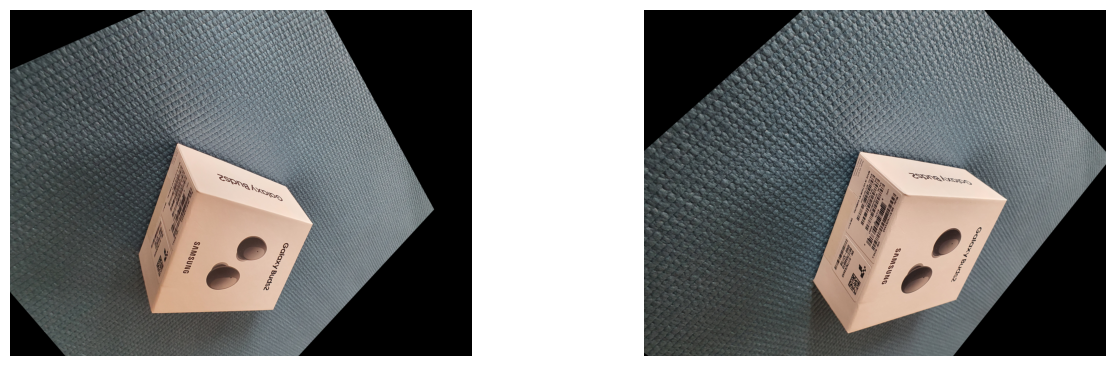

In [18]:
#Applying the rectifying homographies on the images
H_off = np.array([[1,0,0],[0,1,150],[0,0,1]])
h,w,_= img1.shape
  
img1Rect = cv2.warpPerspective(img1,H1,(w,h))
img1Rect = cv2.cvtColor(img1Rect, cv2.COLOR_BGR2RGB)

 
img2Rect = cv2.warpPerspective(img2,H_off@H2,(w,h))
img2Rect = cv2.cvtColor(img2Rect, cv2.COLOR_BGR2RGB)

f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.axis('off')
ax2.axis('off')

ax1.imshow(img1Rect)
ax2.imshow(img2Rect)



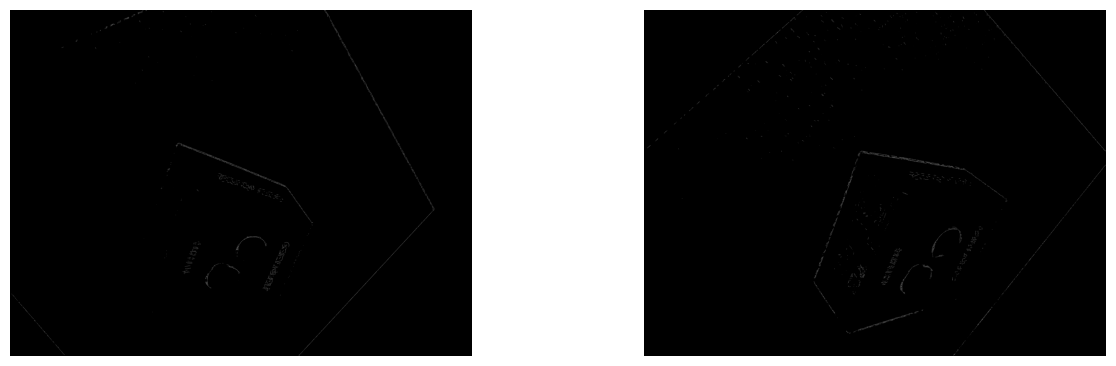

In [19]:
#Applying Canny edge detection on the rectified image
img1edges = Canny(img1Rect)
img2edges = Canny(img2Rect)

f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(121)
ax2 = f.add_subplot(122)
ax1.axis('off')
ax2.axis('off')

ax1.imshow(img1edges,cmap='gray')
ax2.imshow(img2edges,cmap='gray')

  




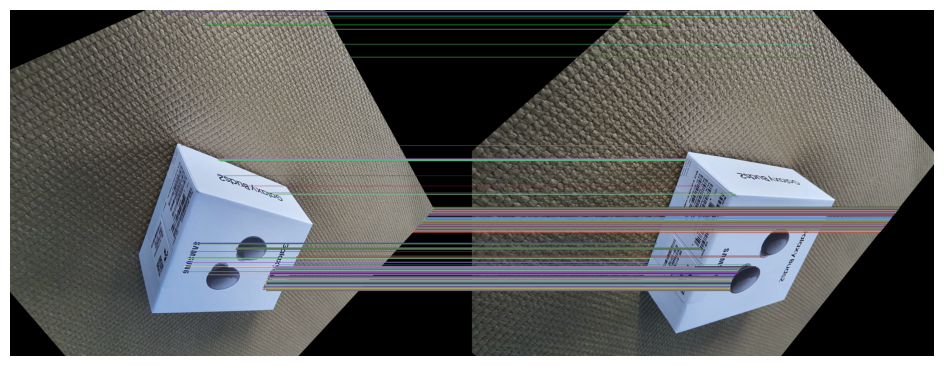

In [20]:
#Finding and displaying the detected correspondences
detected_corrs = img_corrs(img1edges,img2edges,40,15)
corr_img = show_corrs(img1Rect,img2Rect,detected_corrs)
  
f = plt.figure(figsize=(15,4.5))
ax1 = f.add_subplot(111)
ax1.axis('off')

ax1.imshow(corr_img)

  

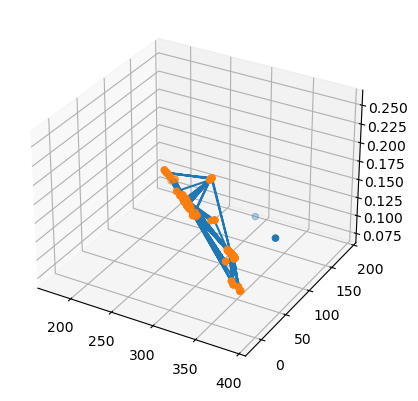

In [21]:
#Displaying the 3D plot using manually and automatically detected correspondences
ones = np.ones((coords1.shape[0],1))
hcoords1 = np.c_[coords1,ones]
hcoords2 = np.c_[coords2,ones]

rhcoords1 = (H1@hcoords1.T).T
rcoords1 = rhcoords1/rhcoords1[:,-1].reshape((coords1.shape[0],1))
rectcoords1 = rcoords1[:,0:2]

rhcoords2 = (H2@hcoords2.T).T
rcoords2 = rhcoords2/rhcoords2[:,-1].reshape((coords2.shape[0],1))
rectcoords2 = rcoords2[:,0:2]

rectCorrs = np.array([list(rectcoords1),list(rectcoords2)])

worldCoords1 = all_world(rectCorrs,P,P_bar)

worldCoords2 = all_world(detected_corrs,P,P_bar)


visualize_Plot(worldCoords1,worldCoords2)